In [1]:
from NoisyCircuits.utils.BuildQubitGateModelParallel import BuildModel as Parallel
from NoisyCircuits.utils.BuildQubitGateModelSingleOptimized import BuildModel as SingleOpt
from NoisyCircuits.utils.BuildQubitGateModel import BuildModel as Single
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import identity, csr_matrix
with open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb") as f:
    noise_model = pickle.load(f)

In [5]:
def reverse_bits(n, num_qubits):
    binary = format(n, f'0{num_qubits}b')
    return int(binary[::-1], 2)

def convert_endian(matrix):
    dim = matrix.shape[0]
    n = int(np.log2(dim))
    perm = [reverse_bits(i, n) for i in range(dim)]
    le_matrix = matrix[np.ix_(perm, perm)]
    return le_matrix

In [47]:
def compare(n_qubits):

    def compare_sparse_two_qubit(mat1, mat2, n_qubits=n_qubits):
        dim = 2**n_qubits
        mat1 = csr_matrix(mat1, shape=(dim, dim)).toarray()
        mat2 = csr_matrix(mat2, shape=(dim, dim)).toarray()
        mat1 = convert_endian(mat1)
        return np.allclose(mat1, mat2)
    
    def compare_sparse(mat1, mat2):
        mat1 = csr_matrix(mat1).toarray()
        mat2 = csr_matrix(mat2).toarray()
        return np.allclose(mat1, mat2)
    
    def compare_dictionaries(dict1, dict2):
        single_old, two_old = dict1
        single_new, two_new = dict2
        for qubit in single_old.keys():
            for gate in single_old[qubit].keys():
                kraus_ops_new = single_new[qubit][gate]["kraus_operators"]
                kraus_ops_old = single_old[qubit][gate]["kraus_operators"]
                for k in range(len(kraus_ops_new)):
                    assert compare_sparse(kraus_ops_new[k], kraus_ops_old[k]), f"Single qubit gate mismatch on qubit {qubit} gate {gate} operator {k}"
                qubit_channel_new = single_new[qubit][gate]["qubit_channel"]
                qubit_channel_old = single_old[qubit][gate]["qubit_channel"]
                for k in range(len(qubit_channel_new)):
                    assert compare_sparse(qubit_channel_new[k], qubit_channel_old[k]), f"Single qubit channel mismatch on qubit {qubit} gate {gate} operator {k}"
            
        for gate in two_old.keys():
            if len(two_old[gate].keys()) == 0:
                continue
            for qubit_pair in two_old[gate].keys():
                kraus_ops_new = two_new[gate][qubit_pair]["operators"]
                kraus_ops_old = two_old[gate][qubit_pair]["operators"]
                for k in range(len(kraus_ops_new)):
                    assert compare_sparse_two_qubit(kraus_ops_new[k], kraus_ops_old[k]), f"Two qubit gate mismatch on qubits {qubit_pair} gate {gate} operator {k}"
                gate_channel_new = two_new[gate][qubit_pair]["qubit_channel"]
                gate_channel_old = two_old[gate][qubit_pair]["qubit_channel"]
                for k in range(len(gate_channel_new)):
                    assert compare_sparse(gate_channel_new[k], gate_channel_old[k]), f"Two qubit channel mismatch on qubits {qubit_pair} gate {gate} operator {k}"
        return True
    
    time_data = {
        "Old" : [],
        "Single": [],
        "Parallel": []
    }
    for _ in range(3):
        t0 = time.perf_counter_ns()
        vals_old = Single(
                    noise_model=noise_model,
                    num_qubits=n_qubits,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_data["Old"].append(t1 - t0)
        t0 = time.perf_counter_ns()
        vals_single = SingleOpt(
                    noise_model=noise_model,
                    num_qubits=n_qubits,
                    num_cores=n_qubits,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_data["Single"].append(t1 - t0)
        t0 = time.perf_counter_ns()
        vals_parallel = Parallel(
                    noise_model=noise_model,
                    num_qubits=n_qubits,
                    num_cores=n_qubits,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_data["Parallel"].append(t1 - t0)
    single_old, two_old, _, _ = vals_old
    single_parallel, two_parallel, _, _ = vals_parallel
    assert compare_dictionaries((single_old, two_old), (single_parallel, two_parallel)), f"Mismatch between parallel and old for {n_qubits} qubits"
    return time_data

In [51]:
qubits_data = {
    "qubits":[],
    "mean": [[], [], []],
    "std": [[], [], []]
}
for n_qubits in range(1, 11):
    data = compare(n_qubits)
    qubits_data["qubits"].append(n_qubits)
    for i, key in enumerate(["Old", "Single", "Parallel"]):
        qubits_data["mean"][i].append(np.mean(data[key]) / 1e9)
        qubits_data["std"][i].append(np.std(data[key]) / 1e9)
    print(f"Completed {n_qubits} qubits.")

Completed 1 qubits.
Completed 2 qubits.
Completed 3 qubits.
Completed 4 qubits.
Completed 5 qubits.
Completed 6 qubits.
Completed 7 qubits.
Completed 8 qubits.
Completed 9 qubits.
Completed 10 qubits.


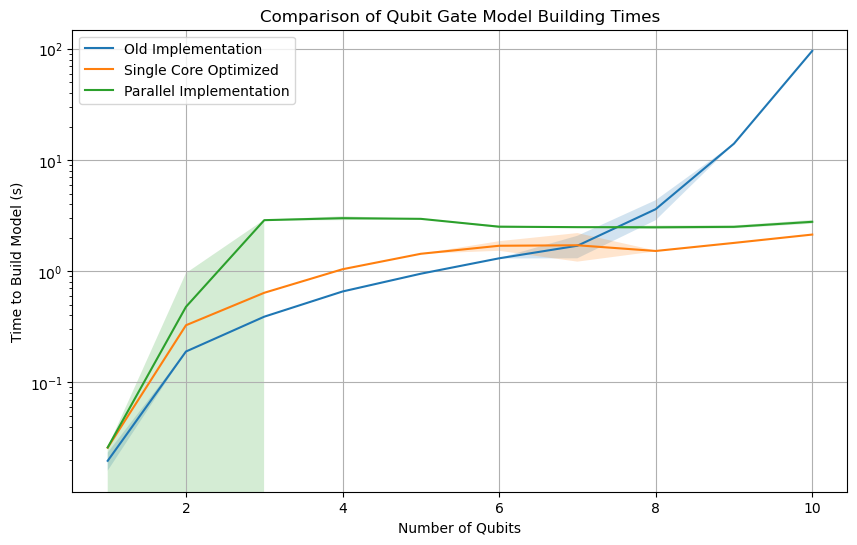

In [52]:
plt.figure(figsize=(10, 6))
label_list = ["Old Implementation", "Single Core Optimized", "Parallel Implementation"]
for i in range(3):
    plt.semilogy(qubits_data["qubits"], qubits_data["mean"][i], label=label_list[i])
    plt.fill_between(qubits_data["qubits"],
                     np.array(qubits_data["mean"][i]) - np.array(qubits_data["std"][i]),
                     np.array(qubits_data["mean"][i]) + np.array(qubits_data["std"][i]),
                     alpha=0.2)
plt.xlabel("Number of Qubits")
plt.ylabel("Time to Build Model (s)")
plt.title("Comparison of Qubit Gate Model Building Times")
plt.legend()
plt.grid()
plt.show()

In [2]:
def compare_times(n):
    time_single = []
    time_parallel = []
    for _ in range(3):
        to = time.perf_counter_ns()
        v = SingleOpt(
            noise_model=noise_model,
            num_qubits=n,
            num_cores=n,
            threshold=1e-15,
            basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
            verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_single.append(t1 - to)
        to = time.perf_counter_ns()
        v = Parallel(
            noise_model=noise_model,
            num_qubits=n,
            num_cores=n,
            threshold=1e-15,
            basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
            verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_parallel.append(t1 - to)
    return time_single, time_parallel

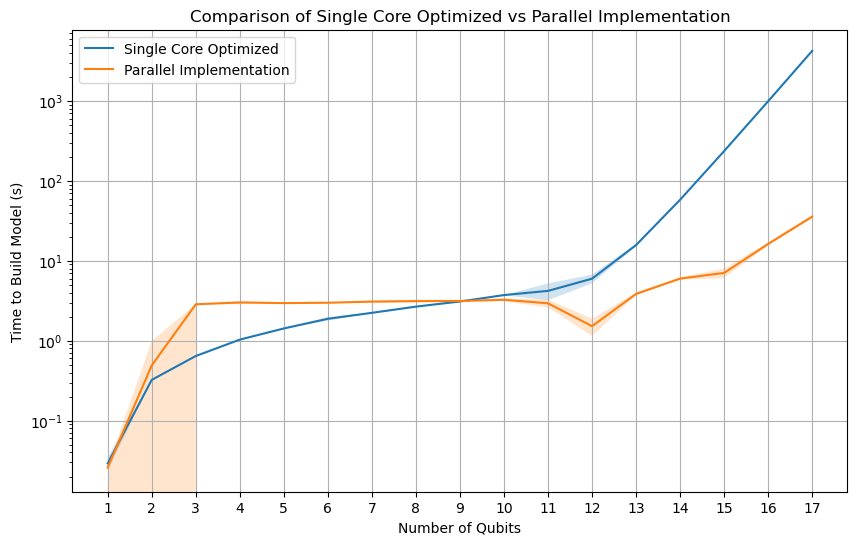

In [5]:
data = {
    "qubits": [],
    "means": [[], []],
    "stds": [[], []]
}
for i in range(1, 18):
    times = compare_times(i)
    data["qubits"].append(i)
    for j in range(2):
        data["means"][j].append(np.mean(times[j]) / 1e9)
        data["stds"][j].append(np.std(times[j]) / 1e9)

plt.figure(figsize=(10, 6))
labels = ["Single Core Optimized", "Parallel Implementation"]
for i in range(2):
    plt.semilogy(data["qubits"], data["means"][i], label=labels[i])
    plt.fill_between(data["qubits"],
                     np.array(data["means"][i]) - np.array(data["stds"][i]),
                     np.array(data["means"][i]) + np.array(data["stds"][i]),
                     alpha=0.2)
plt.xlabel("Number of Qubits")
plt.ylabel("Time to Build Model (s)")
plt.title("Comparison of Single Core Optimized vs Parallel Implementation")
plt.legend()
plt.xticks(data["qubits"])
plt.grid()
plt.show()